# Follow-up on activation functions in (multi-layer) perceptrons

How do we tell which activation function is being used in a model?

`nn.Linear` itself has no activation function - it's just a linear transformation.

The activation (if any) comes from what you do with its output.


In [25]:
import torch
from torch import nn, optim
model = nn.Linear(2, 1)
print(model)

# Linear activation (no activation)
outputs = model(X)  # Just the raw linear output

# Sigmoid activation
outputs = torch.sigmoid(model(X))  # Explicitly apply sigmoid

# Or implicitly in the loss function
criterion = nn.BCEWithLogitsLoss()  # Applies sigmoid internally

Linear(in_features=2, out_features=1, bias=True)


NameError: name 'X' is not defined

This may be a bit opaque, especially for people who are using PyTorch for the first time.
To make it explicit in your model, you can define the activation as part of the model:

In [26]:
# Linear activation (identity)
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Identity()  # Explicit linear activation (no operation)
)
print(model)

# Sigmoid activation
model = nn.Sequential(
    nn.Linear(2, 1),
    nn.Sigmoid()
)
print(model)

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Identity()
)
Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)


# Introduction to minimizing loss function

Today we would like to expand on an important topic in physics and machine learning.
This is the topic of minimization of multivariate functions.
It turns out that this topic has applications in quantum mechanics (energy), statistics (likelihood), and mechanics (least action).
Of course, the "minimization" of a function can be used to find a minimum or maximum value -- just multiply by -1 to switch it around.

When we search for a minimum, we are searching for an extremum where the first derivative $d L / d x = 0$ (1-dimensional) or $\nabla L = 0$ (multi-dimensional).

## Basic idea of minimization

Remember the basic idea in the method:
* expand the function $f(x)$ about the current best guess for $x$
* approximate the Taylor series expansion with the first two terms (constant plus first derivative)
* solve the resulting *linear* equation for a new best guess for $x$
* repeat until the value of $f(x)$ is close enough to 0

<img src="https://raw.githubusercontent.com/JasonNielsen/phys152-2026/main/Notebooks/images/minimization.png" width="500">

Starting with any approximate solutions $x_i$, we would like to know the set of
corrections $\Delta x_i$ for which

$$f (x_1+\Delta x_1, x_2+\Delta x_2, \ldots)= 0$$

If our approximate solution is close enough to the true solution ($\Delta x_i$ are all small), then we can expand the function at that point and keep only the linear terms in the Taylor series expansion:

$$
f(x_1+\Delta x_1,\ldots) \simeq f (x_1,\ldots) +
\sum \frac{\partial f} {\partial x_j} \Delta x_j = 0
$$




### Method of Steepest (Gradient) Descent (Linear Approximation)

We explored very carefully the Newton-Raphson method for solving an equation in 1 dimension.
It seems reasonable to try and apply the same method for the minimization of a multivariate function like the loss function.
Because the gradient vector ${\bf G}({\bf x})$ points in the direction of the steepest ascent, we know that $-{\bf G}({\bf x})$ points in the direction of the steepest descent.
This is what we want for a minimization problem.

In fact, the rate of change of $L$ in the direction of $\bf \Delta x$ is simply

$${\bf G}({\bf x})^T {\bf \Delta x}$$

(If this is not clear, try constructing the partial derivative of $L$ at $\bf x$.)

To find the minimum (extremum), we would like to move as quickly as possible "downhill" to the minimum.
We need to find a unit vector $\bf \Delta x$ that maximizes the (negative) rate of change.
It turns out that the correct unit vector is simply along the steepest descent.  This seems obvious in hindsight.

We need to find the multiplicative constant $k$ that minimizes
$$L({\bf x} + k{\bf G}({\bf x}))$$

Then we can update the best guess for ${\bf x}$ to be ${\bf x} + k{\bf G}({\bf x})$.

Perhaps we do not want to use the optimal step $k{\bf G}({\bf x})$. Perhaps we want to be more conservative or more agressive. In that case we would modify $k$ by a learning rate parameter. (The PyTorch default for SGD is 0.01.)



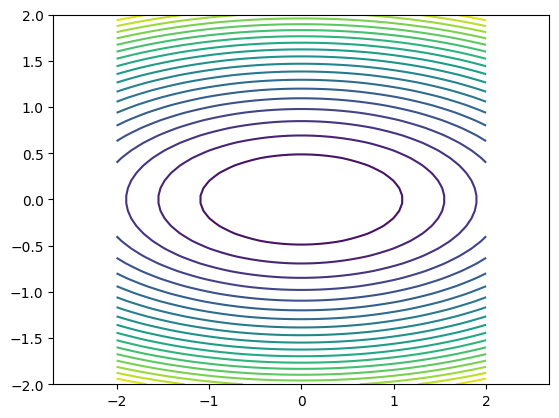

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sopt

def F(x):
    return 0.5*x[0]**2 + 2.5*x[1]**2

def dF(x):
    # Precomputed analytic derivatives (gradient vector)
    return np.array([x[0], 5*x[1]])

xmesh, ymesh = np.mgrid[-2:2:50j,-2:2:50j] #50 points in each direction, a terrible Python hack
fmesh = F(np.array([xmesh, ymesh]))

plt.axis("equal")
plt.contour(xmesh, ymesh, fmesh, 20)
plt.show()

In [ ]:
x_values = [np.array([2., 0.4])]
x = x_values[-1]

def f1d(k):
    return F(x + k*G)

k = 0.
for i in range(10):
    G = -dF(x)
    k = (sopt.minimize(f1d, k)).x # Minimize returns a OptimizeResult object
    next_x = x + k*G
    x_values.append(next_x)
    x = next_x

# Get a list of the iterated minimum points
print(x_values)

[array([2. , 0.4]), array([ 1.33333333, -0.26666667]), array([0.88888889, 0.17777778]), array([ 0.59259259, -0.11851852]), array([0.39506173, 0.07901234]), array([ 0.26337449, -0.0526749 ]), array([0.17558299, 0.0351166 ]), array([ 0.11705533, -0.02341106]), array([0.07803688, 0.01560738]), array([ 0.05202459, -0.01040492]), array([0.03468306, 0.00693661])]


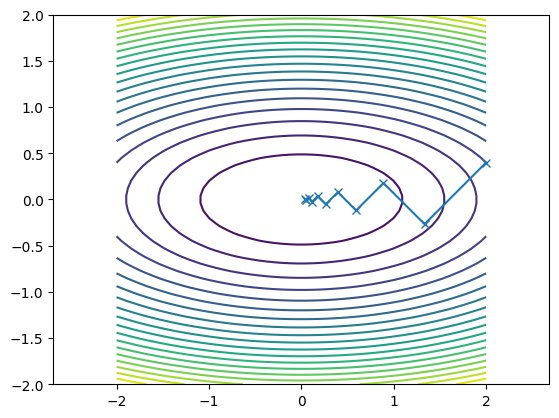

In [ ]:
plotting_array = np.array(x_values)
plt.axis("equal")
plt.contour(xmesh, ymesh, fmesh, 20)
plt.plot(plotting_array.T[0],plotting_array.T[1], "x-")
plt.show()

This was done with the SciPy optimizer, which may calculate numerical approximations to the gradient.
(In this example it used our precalculated derivatives.)

By contrast, PyTorch never uses numerical approximations because it can calculate the derivatives analytically by using the chain rule.

In [33]:
x = torch.tensor([2.0], requires_grad=True)
y = torch.tensor([-0.4], requires_grad=True)

def F(x, y):
    return 0.5*x**2 + 2.5*y**2

optimizer = torch.optim.SGD([x,y], lr=0.4, momentum=0.0, nesterov=False)

for i in range(20):
    optimizer.zero_grad()
    loss = F(x, y)
    loss.backward()
    optimizer.step()
    print(x, y)

tensor([1.2000], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.7200], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.4320], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.2592], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.1555], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.0933], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.0560], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.0336], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.0202], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.0121], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.0073], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.0044], requires_grad=True) tensor([-0.4000], requires_grad=True)
tensor([0.0026], requires_grad=True) tensor([0.4000], requires_grad=True)
tensor([0.0016], requires_grad=T

What happens if you make the learning rate larger or smaller?

You can also try this using other optimizers like LBFGS, ADAM, or NAG.